# Attention models for Time Series

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A notebook from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).


## Toy seq2seq task

For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = np.random.rand(1)[0] * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 10.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #1.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

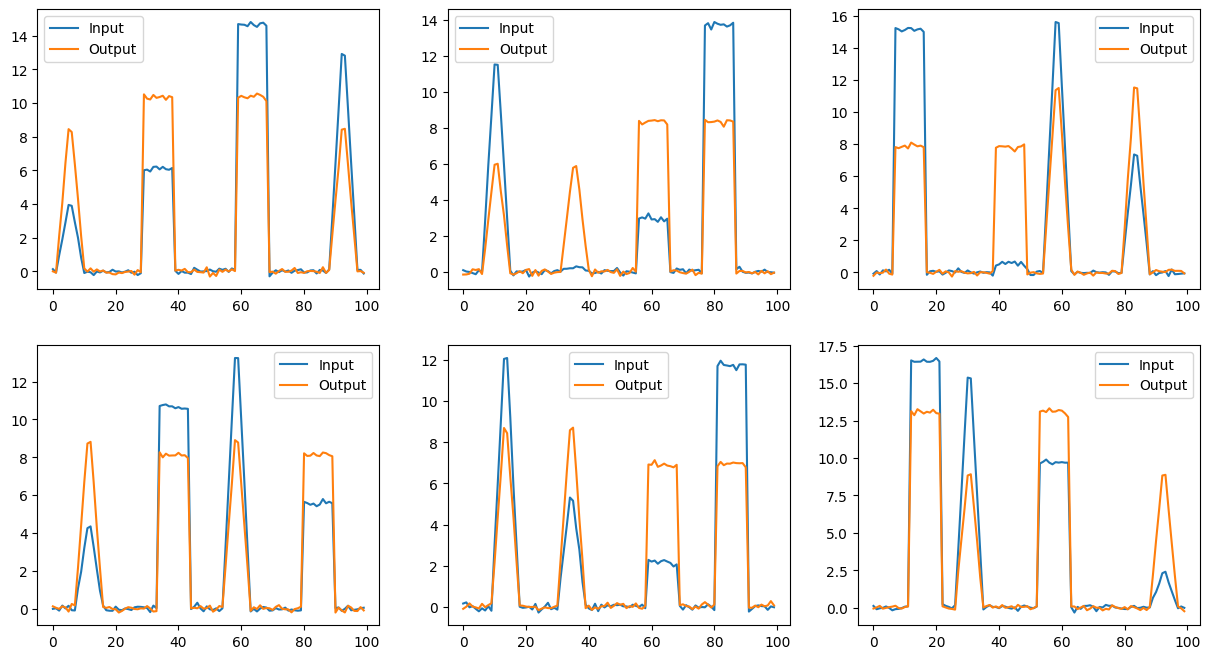

In [3]:
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(inputs[i, :, 0], label="Input")
    plt.plot(outputs[i, :, 0], label="Output")
    plt.legend();

**Question #2.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D

conv_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="relu", padding="same")
])
conv_model.compile(optimizer="adam", loss="mse")
h_conv = conv_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100)

2023-01-31 15:28:53.263177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4/4 [==============================] - 2s 140ms/step - loss: 27.7308 - val_loss: 22.0434
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 16.2333 - val_loss: 8.9868
Epoch 3/100
4/4 [==============================] - 0s 61ms/step - loss: 10.3591 - val_loss: 7.1252
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 7.6136 - val_loss: 7.5141
Epoch 5/100
4/4 [==============================] - 0s 45ms/step - loss: 7.0530 - val_loss: 6.5665
Epoch 6/100
4/4 [==============================] - 0s 44ms/step - loss: 6.9075 - val_loss: 6.0793
Epoch 7/100
4/4 [==============================] - 0s 83ms/step - loss: 6.2728 - val_loss: 6.0661
Epoch 8/100
4/4 [==============================] - 0s 63ms/step - loss: 6.0882 - val_loss: 5.7391
Epoch 9/100
4/4 [==============================] - 0s 69ms/step - loss: 5.9736 - val_loss: 5.6089
Epoch 10/100
4/4 [==============================] - 0s 70ms/step - loss: 5.7928 - val_loss: 5.6054
Epoch 11/100
4

**Question #3.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [12]:
from tensorflow.keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)
    
att_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    MultiHeadSelfAttention(num_heads=1, key_dim=65),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="relu", padding="same")
])
att_model.compile(optimizer="adam", loss="mse")
h_att = att_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100)

Epoch 1/100
32/32 [==============================] - 3s 50ms/step - loss: 14.8865 - val_loss: 7.4081
Epoch 2/100
32/32 [==============================] - 2s 50ms/step - loss: 3.4390 - val_loss: 2.9753
Epoch 3/100
32/32 [==============================] - 1s 45ms/step - loss: 1.9981 - val_loss: 2.4673
Epoch 4/100
32/32 [==============================] - 1s 44ms/step - loss: 1.8312 - val_loss: 2.2992
Epoch 5/100
32/32 [==============================] - 1s 45ms/step - loss: 1.7686 - val_loss: 2.1680
Epoch 6/100
32/32 [==============================] - 1s 44ms/step - loss: 1.6145 - val_loss: 1.9374
Epoch 7/100
32/32 [==============================] - 1s 45ms/step - loss: 1.4179 - val_loss: 1.8422
Epoch 8/100
32/32 [==============================] - 2s 48ms/step - loss: 1.1809 - val_loss: 1.6535
Epoch 9/100
32/32 [==============================] - 2s 48ms/step - loss: 1.0936 - val_loss: 1.6264
Epoch 10/100
32/32 [==============================] - 2s 60ms/step - loss: 1.0116 - val_loss: 1.687

KeyboardInterrupt: 

**Question #4.** Compare both models in terms of validation loss.

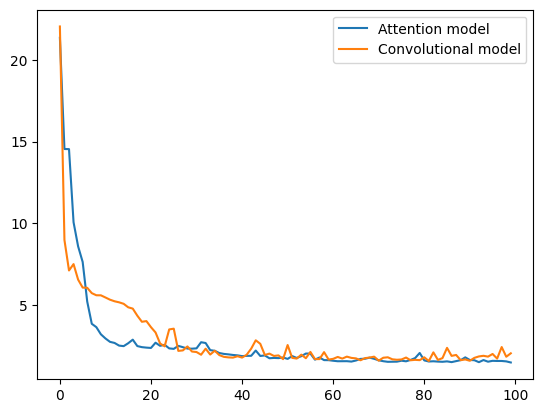

In [13]:
plt.plot(h_att.history["val_loss"], label="Attention model")
plt.plot(h_conv.history["val_loss"], label="Convolutional model")
plt.legend();

**Question #5.** Use test data for qualitative inspection of the produced outputs.

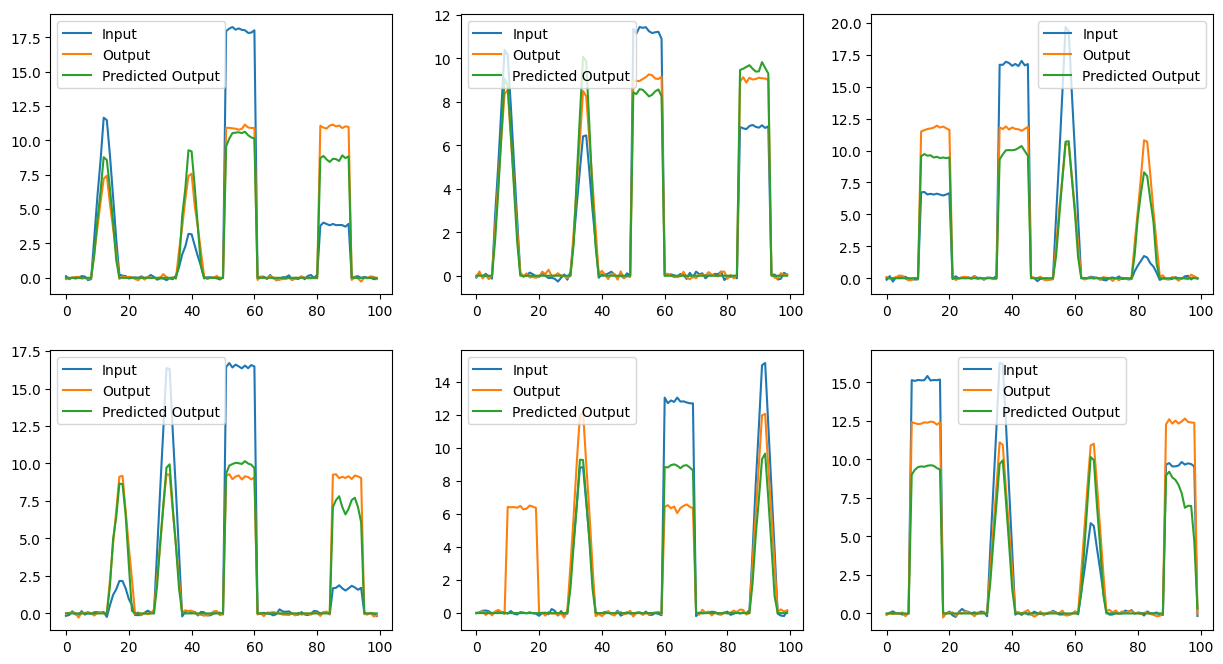

In [15]:
preds = conv_model(test_inputs)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], label="Input")
    plt.plot(test_outputs[i, :, 0], label="Output")
    plt.plot(preds[i, :, 0], label="Predicted Output")
    plt.legend();

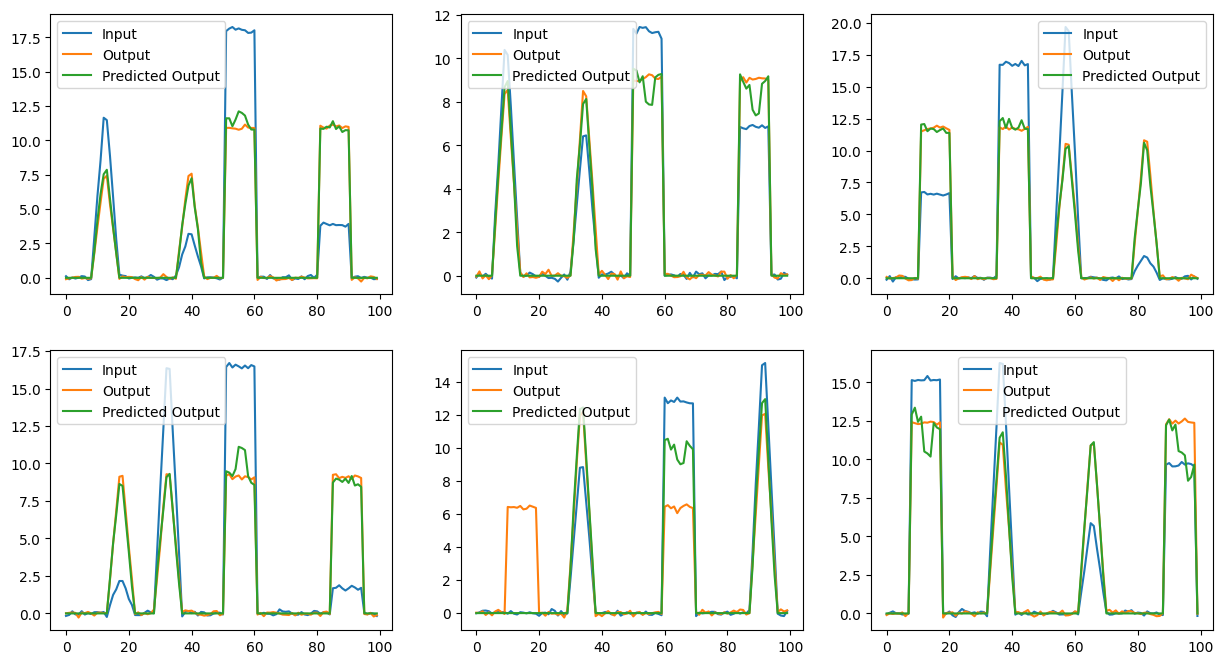

In [14]:
preds = att_model(test_inputs)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], label="Input")
    plt.plot(test_outputs[i, :, 0], label="Output")
    plt.plot(preds[i, :, 0], label="Predicted Output")
    plt.legend();

**Question #6.** Use the code below to visualize average attention scores for the first 3 test series.

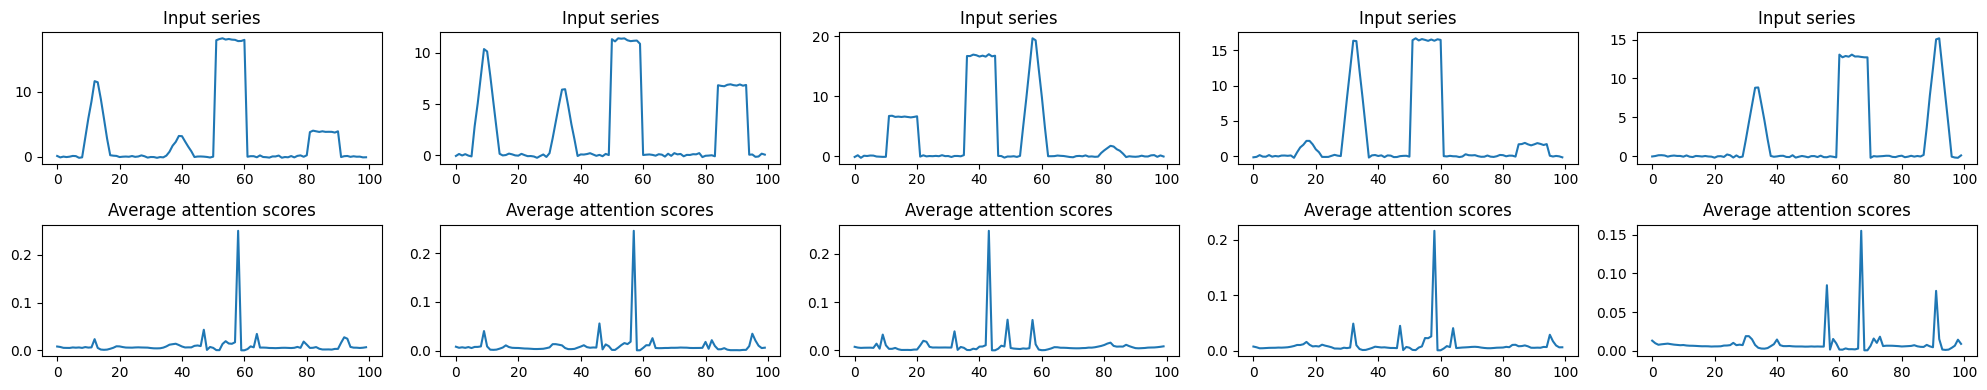

In [17]:
from tensorflow.keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    output_tensor, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()

visualize_average_attention_scores(att_model, index_of_attention_layer=2, time_series=test_inputs[:5])

## Attention models for Time Series Classification

In this section, you will design a model that relies on attention for the Trace dataset you already used in previous labs.

**Question #7.** Load the Trace dataset, merge training and test data and shuffle the resulting dataset.

In [23]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

y_train -= 1
y_test -= 1

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

indices = np.random.choice(len(X), size=len(X), replace=False)
X = X[indices]
y = y[indices]

print(X.shape, y.shape)

(200, 275, 1) (200,)


**Question #8.** Using only convolutions, self-attention and dense layers, design a first neural network architecture for the task at hand. You will use 20% of the data as validation (see the `validation_split` argument of the `model.fit` function).

In [25]:
from tensorflow.keras.layers import Dense, Flatten, MaxPool1D

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    MultiHeadSelfAttention(num_heads=6, key_dim=64),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X, y, validation_split=0.2, epochs=100)

Epoch 1/100
5/5 [==============================] - 2s 161ms/step - loss: 1.3949 - accuracy: 0.2438 - val_loss: 1.3781 - val_accuracy: 0.2750
Epoch 2/100
5/5 [==============================] - 1s 109ms/step - loss: 1.3948 - accuracy: 0.1813 - val_loss: 1.3904 - val_accuracy: 0.1500
Epoch 3/100
5/5 [==============================] - 0s 99ms/step - loss: 1.3819 - accuracy: 0.2750 - val_loss: 1.3893 - val_accuracy: 0.1500
Epoch 4/100
5/5 [==============================] - 1s 108ms/step - loss: 1.3659 - accuracy: 0.2750 - val_loss: 1.3647 - val_accuracy: 0.1500
Epoch 5/100
5/5 [==============================] - 1s 144ms/step - loss: 1.3212 - accuracy: 0.4563 - val_loss: 1.2785 - val_accuracy: 0.2500
Epoch 6/100
5/5 [==============================] - 1s 114ms/step - loss: 1.2076 - accuracy: 0.4062 - val_loss: 1.0093 - val_accuracy: 0.5250
Epoch 7/100
5/5 [==============================] - 1s 154ms/step - loss: 1.0055 - accuracy: 0.4812 - val_loss: 0.7932 - val_accuracy: 0.6750
Epoch 8/100
5/

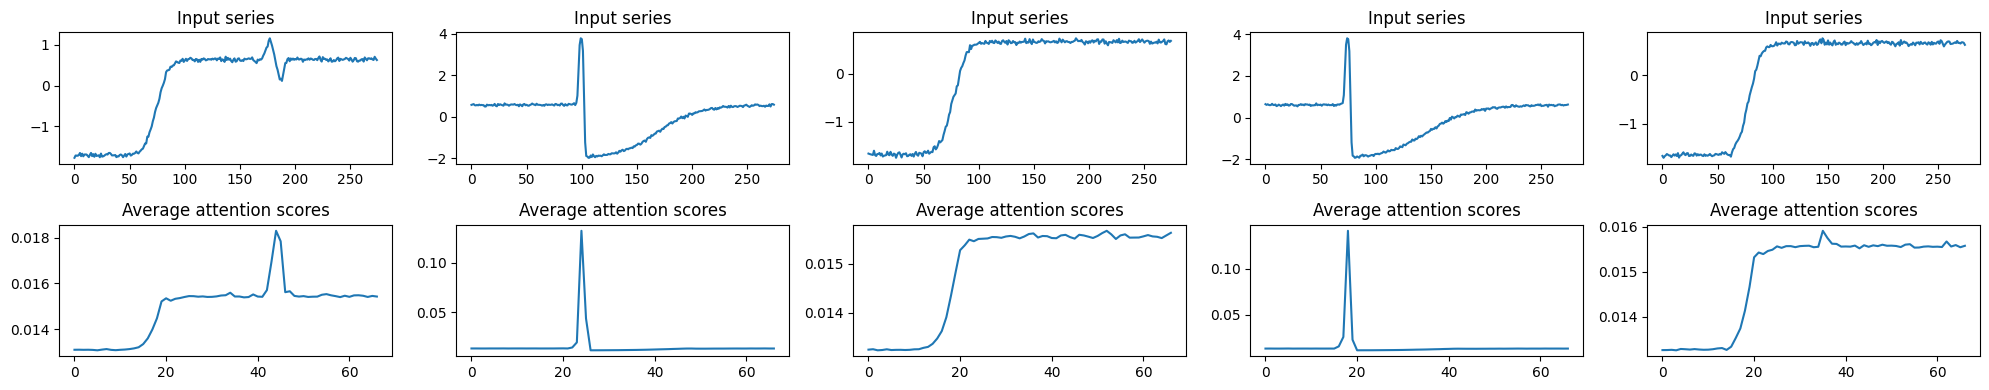

In [26]:
visualize_average_attention_scores(model, index_of_attention_layer=4, time_series=X[:5])

**Question #9.** Sub-class the `Conv1D` layer to implement a residual layer that would compute its output as:

$$\text{ResidualConv}(x) = x + \text{Conv}(x)$$

where $\text{Conv}(x)$ is a 1d convolution applied to the input series $x$.

Why would it make sense to use such a layer in place of a convolutional one?

In [28]:
class ResConv1D(Conv1D):
    def __init__(self, filters, kernel_size, activation="linear"):
        super().__init__(filters, kernel_size, activation=activation, padding="same")

    def call(self, x):
        return x + super().call(x)

**Question #10.** Replace convolutional layers by residual convolutional layers in your previous model and see if performance is improved.

In [29]:
model = Sequential([
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    MultiHeadSelfAttention(num_heads=6, key_dim=64),
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X, y, validation_split=0.2, epochs=20)

Epoch 1/20
5/5 [==============================] - 2s 201ms/step - loss: 1.2086 - accuracy: 0.3688 - val_loss: 0.5366 - val_accuracy: 0.7000
Epoch 2/20
5/5 [==============================] - 1s 105ms/step - loss: 0.5612 - accuracy: 0.7312 - val_loss: 0.5482 - val_accuracy: 0.6750
Epoch 3/20
5/5 [==============================] - 0s 102ms/step - loss: 0.4409 - accuracy: 0.7188 - val_loss: 0.6350 - val_accuracy: 0.6750
Epoch 4/20
5/5 [==============================] - 1s 103ms/step - loss: 0.3518 - accuracy: 0.8313 - val_loss: 0.2651 - val_accuracy: 0.9250
Epoch 5/20
5/5 [==============================] - 1s 145ms/step - loss: 0.1912 - accuracy: 0.9062 - val_loss: 0.1658 - val_accuracy: 0.9000
Epoch 6/20
5/5 [==============================] - 1s 113ms/step - loss: 0.1510 - accuracy: 0.9375 - val_loss: 0.0849 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 1s 165ms/step - loss: 0.0504 - accuracy: 0.9875 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 8/20
5/5 [====